Preprocessing of the zebrafish data
----
Preprocessing, merging annotations and plotting them on provided embeddings. T

# Preliminaries

## Dependecy notebooks

This is the first of a series of notebooks. 

## Import packages

If you want modules to be automatically reloaded when you call them, use `autoreload`:

In [1]:
%load_ext autoreload
%autoreload 2

Import packages

In [2]:
# import standard packages
import numpy as np
import pandas as pd 
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

import os
import sys

# import single-cell packages
import scanpy as sc
import scvelo as scv
import cellrank as cr
from cellrank._utils._colors import _convert_to_hex_colors

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3 

Global seed set to 0


## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [3]:
cr.logging.print_versions()

cellrank==1.5.2.dev206+ga2748bea scanpy==1.9.3 anndata==0.8.0 numpy==1.24.2 numba==0.57.0rc1 scipy==1.10.1 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.0 seaborn==0.12.2


In [4]:
cr.logging.print_version_and_date()

Running CellRank 1.5.2.dev206+ga2748bea, on 2023-07-17 16:32.


## Set up paths

In [5]:
sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

# adjust directories
DATA_DIR = DATA_DIR / "cytotrace_kernel" / "validation"
FIG_DIR = FIG_DIR / "cytotrace_kernel" / "validation"

scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Utility functions

In [6]:
def remap_colors(adata, key, color_map='gnuplot'):
    """Utlility to change the coloring """
    n_colors = len(adata.obs[key].cat.categories)
    adata.uns[f"{key}_colors"] = _convert_to_hex_colors(sns.color_palette(color_map, n_colors=n_colors))

In [7]:
def remove_from_obs(adata, key):
    if key in adata.obs.keys():
        del adata.obs[key]

## Set global parameters

Set some plotting parameters.

In [8]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

Set other global parameters

In [9]:
# should figures just be displayed or also saved?
save_figure = False

If there are other global parameters for this analysis, put them here as well. 

## Load cellranger data

There are standard count matrices, the output of running a standard alignment pipeline. 

In [10]:
adata = sc.read(DATA_DIR / "zebrafish" / "GSE106474_UMICounts.txt").T
adata

AnnData object with n_obs × n_vars = 39505 × 23974

## Import metadata

Import original study metadata

In [11]:
study_metadata = pd.read_csv(DATA_DIR / "zebrafish" / "metadata" / "URD_Dropseq_Meta.txt", sep='\t', skiprows=[1], index_col=0)
print(study_metadata.shape)
study_metadata.head()

(38731, 27)


Stage  Segment  Lineage_Spinal_Cord  \
NAME                                                                  
ZFHIGH_WT_DS5_AAAAGTTGCCTC  03.3-HIGH     82.0                 True   
ZFHIGH_WT_DS5_AAACAAGTGTAT  03.3-HIGH     82.0                 True   
ZFHIGH_WT_DS5_AAACACCTCGTC  03.3-HIGH     82.0                 True   
ZFHIGH_WT_DS5_AAATGAGGTTTN  03.3-HIGH     38.0                False   
ZFHIGH_WT_DS5_AACCCTCTCGAT  03.3-HIGH     82.0                 True   

                            Lineage_Diencephalon  Lineage_Optic_Cup  \
NAME                                                                  
ZFHIGH_WT_DS5_AAAAGTTGCCTC                  True               True   
ZFHIGH_WT_DS5_AAACAAGTGTAT                  True               True   
ZFHIGH_WT_DS5_AAACACCTCGTC                  True               True   
ZFHIGH_WT_DS5_AAATGAGGTTTN                 False              False   
ZFHIGH_WT_DS5_AACCCTCTCGAT                  True               True   

                            Lineage_Midbrain_Neural_Crest  \
NAME                                                        
ZFHIGH_WT_DS5_AAAAGTTGCCTC                           True   
ZFHIGH_WT_DS5_AAACAAGTGTAT                           True   
ZFHIGH_WT_DS5_AAACACCTCGTC                           True   
ZFHIGH_WT_DS5_AAATGAGGTTTN                          False   
ZFHIGH_WT_DS5_AACCCTCTCGAT                           True   

                            Lineage_Hindbrain_R3  Lineage_Hindbrain_R4_5_6  \
NAME                                                                         
ZFHIGH_WT_DS5_AAAAGTTGCCTC                  True                      True   
ZFHIGH_WT_DS5_AAACAAGTGTAT                  True                      True   
ZFHIGH_WT_DS5_AAACACCTCGTC                  True                      True   
ZFHIGH_WT_DS5_AAATGAGGTTTN                 False                     False   
ZFHIGH_WT_DS5_AACCCTCTCGAT                  True                      True   

                            Lineage_Telencephalon  Lineage_Epidermis  ...  \
NAME                                                                  ...   
ZFHIGH_WT_DS5_AAAAGTTGCCTC                   True               True  ...   
ZFHIGH_WT_DS5_AAACAAGTGTAT                   True               True  ...   
ZFHIGH_WT_DS5_AAACACCTCGTC                   True               True  ...   
ZFHIGH_WT_DS5_AAATGAGGTTTN                  False              False  ...   
ZFHIGH_WT_DS5_AACCCTCTCGAT                   True               True  ...   

                            Lineage_Hematopoeitic_ICM  \
NAME                                                    
ZFHIGH_WT_DS5_AAAAGTTGCCTC                       True   
ZFHIGH_WT_DS5_AAACAAGTGTAT                       True   
ZFHIGH_WT_DS5_AAACACCTCGTC                       True   
ZFHIGH_WT_DS5_AAATGAGGTTTN                      False   
ZFHIGH_WT_DS5_AACCCTCTCGAT                       True   

                            Lineage_Hematopoeitic_RBI_Pronephros  \
NAME                                                               
ZFHIGH_WT_DS5_AAAAGTTGCCTC                                  True   
ZFHIGH_WT_DS5_AAACAAGTGTAT                                  True   
ZFHIGH_WT_DS5_AAACACCTCGTC                                  True   
ZFHIGH_WT_DS5_AAATGAGGTTTN                                 False   
ZFHIGH_WT_DS5_AACCCTCTCGAT                                  True   

                            Lineage_Endoderm_Pharyngeal  \
NAME                                                      
ZFHIGH_WT_DS5_AAAAGTTGCCTC                         True   
ZFHIGH_WT_DS5_AAACAAGTGTAT                         True   
ZFHIGH_WT_DS5_AAACACCTCGTC                         True   
ZFHIGH_WT_DS5_AAATGAGGTTTN                        False   
ZFHIGH_WT_DS5_AACCCTCTCGAT                         True   

                            Lineage_Endoderm_Pancreatic_Intestinal  \
NAME                                                                 
ZFHIGH_WT_DS5_AAAAGTTGCCTC                                    True   
ZFHIGH_WT_DS5_AAACAA

Import force directed graph layout

In [12]:
force_directed_graph = pd.read_csv(DATA_DIR / "zebrafish" / "metadata" / "URD_Dropseq_Cluster_URDDevelopmentalTree.txt", sep='\t', 
                                   skiprows=[1], index_col=0)
force_directed_graph.columns = names=[f"{c}_force_directed" for c in ["X", "Y", "Z"]]
print(force_directed_graph.shape)
force_directed_graph.head()

(26434, 3)


X_force_directed  Y_force_directed  Z_force_directed
NAME                                                                         
ZFB_WT_DS3_AATTACGCCCCG          0.855682          0.223750         -0.230581
ZFB_WT_DS3_ATCACTGTAGGG          0.872692          0.218604         -0.224357
ZFB_WT_DS3_CACAATTCTGTG          0.875795          0.220669         -0.226735
ZFB_WT_DS3_CGGCTCTGCCCN          0.875383          0.217352         -0.222521
ZFB_WT_DS3_CGTGCCAACATC          0.906159          0.193935         -0.199125

Import tsne representation

In [13]:
tsne = pd.read_csv(DATA_DIR / "zebrafish" / "metadata" / "URD_Dropseq_Cluster_tSNEAll.txt", sep='\t', skiprows=[1], index_col=0)
tsne.columns = names=[f"{c}_tsne" for c in ["X", "Y"]]
print(tsne.shape)
tsne.head()

(38731, 2)


X_tsne     Y_tsne
NAME                                            
ZFHIGH_WT_DS5_AAAAGTTGCCTC  31.990923 -15.293664
ZFHIGH_WT_DS5_AAACAAGTGTAT  33.267645 -14.519984
ZFHIGH_WT_DS5_AAACACCTCGTC  32.204131 -15.490628
ZFHIGH_WT_DS5_AAATGAGGTTTN  31.882465 -16.132464
ZFHIGH_WT_DS5_AACCCTCTCGAT  31.281623 -16.681426

Import CytoTrace annotations

In [14]:
cyto_trace = pd.read_csv(DATA_DIR / "cytotrace_examples" / "Zebrafish_metadata.txt", sep='\t')
cyto_trace.columns = ['ct_phenotype', 'ct_ground_truth', 'ct_component_1', 'ct_component_2', 'ct_score']
print(cyto_trace.shape)
cyto_trace.head()

(39505, 5)


ct_phenotype  ct_ground_truth  ct_component_1  \
ZFHIGH_WT_DS5_AAAAGTTGCCTC       ZFHIGH                1   131247.864457   
ZFHIGH_WT_DS5_AAACAAGTGTAT       ZFHIGH                1   136093.842242   
ZFHIGH_WT_DS5_AAACACCTCGTC       ZFHIGH                1   135809.228704   
ZFHIGH_WT_DS5_AAATGAGGTTTN       ZFHIGH                1   135808.319857   
ZFHIGH_WT_DS5_AACCCTCTCGAT       ZFHIGH                1   132566.285270   

                            ct_component_2  ct_score  
ZFHIGH_WT_DS5_AAAAGTTGCCTC   -21363.330194   39208.0  
ZFHIGH_WT_DS5_AAACAAGTGTAT   -13473.724217   32655.0  
ZFHIGH_WT_DS5_AAACACCTCGTC   -14509.904803   39425.0  
ZFHIGH_WT_DS5_AAATGAGGTTTN   -14282.676017   39328.0  
ZFHIGH_WT_DS5_AACCCTCTCGAT   -18442.465801   39324.0

Import extra obs annotations, including terminal cell type labels

In [15]:
labels = pd.read_csv(DATA_DIR / "zebrafish" / "metadata" / "2021-03-10_cluster_labels.csv", index_col=0)
print(labels.shape)
labels.head()

(4404, 12)


init  Louvain-15  Louvain-20  Louvain-30  \
ZF6S_WT_DS5_AAAAATACTCTT  ZF6S          29          27          25   
ZF6S_WT_DS5_AAAAATCGCGTN  ZF6S          19          15          14   
ZF6S_WT_DS5_AAAACATTTTAA  ZF6S          27          24          22   
ZF6S_WT_DS5_AAAACCACATGT  ZF6S           7           8           9   
ZF6S_WT_DS5_AAAACGTCCATG  ZF6S          25           9           7   

                          ZF6S-Infomap-30  ZF6S-Infomap-20  \
ZF6S_WT_DS5_AAAAATACTCTT               12                3   
ZF6S_WT_DS5_AAAAATCGCGTN               35               24   
ZF6S_WT_DS5_AAAACATTTTAA               23               25   
ZF6S_WT_DS5_AAAACCACATGT               16               10   
ZF6S_WT_DS5_AAAACGTCCATG               10               19   

                                  ZF6S-Cluster  ZF6S-Cluster-Num  segment  \
ZF6S_WT_DS5_AAAAATACTCTT             Optic Cup               9.0      2.0   
ZF6S_WT_DS5_AAAAATCGCGTN                   NaN               NaN      NaN   
ZF6S_WT_DS5_AAAACATTTTAA  Diencephalon Ventral              19.0     19.0   
ZF6S_WT_DS5_AAAACCACATGT               Tailbud              13.0      3.0   
ZF6S_WT_DS5_AAAACGTCCATG       Somites Forming               7.0     12.0   

                           node  ZF6S-Tips ZF6S-Tips-Named  
ZF6S_WT_DS5_AAAAATACTCTT    2-1        2.0       Optic Cup  
ZF6S_WT_DS5_AAAAATCGCGTN    NaN        NaN             NaN  
ZF6S_WT_DS5_AAAACATTTTAA   19-1       19.0    Diencephalon  
ZF6S_WT_DS5_AAAACCACATGT    3-1        3.0         Tailbud  
ZF6S_WT_DS5_AAAACGTCCATG  12-17        NaN             NaN

Note: this only includes cells from the final stage (6-somite)

## Merge metadata

Merge the study annotation

In [16]:
# join annotations
obs_updated = adata.obs.join(study_metadata, how='inner')

# restrict anndata to subset
adata = adata[obs_updated.index].copy()

# make sure the ordering of cells matches
assert((adata.obs_names == obs_updated.index).all()), "Annotation mismatch"

# copy new annotations into adata
adata.obs = obs_updated
adata

AnnData object with n_obs × n_vars = 38731 × 23974
    obs: 'Stage', 'Segment', 'Lineage_Spinal_Cord', 'Lineage_Diencephalon', 'Lineage_Optic_Cup', 'Lineage_Midbrain_Neural_Crest', 'Lineage_Hindbrain_R3', 'Lineage_Hindbrain_R4_5_6', 'Lineage_Telencephalon', 'Lineage_Epidermis', 'Lineage_Neural_Plate_Border', 'Lineage_Placode_Adeno._Lens_Trigeminal', 'Lineage_Placode_Epibranchial_Otic', 'Lineage_Placode_Olfactory', 'Lineage_Tailbud', 'Lineage_Adaxial_Cells', 'Lineage_Somites', 'Lineage_Hematopoeitic_ICM', 'Lineage_Hematopoeitic_RBI_Pronephros', 'Lineage_Endoderm_Pharyngeal', 'Lineage_Endoderm_Pancreatic_Intestinal', 'Lineage_Heart_Primordium', 'Lineage_Cephalic_Mesoderm', 'Lineage_Prechordal_Plate', 'Lineage_Notochord', 'Lineage_Primordial_Germ_Cells', 'Lineage_EVL'

Merge the tsne annotation

In [17]:
# join annotations
obs_updated = adata.obs.join(tsne, how='inner')

# restrict anndata to subset
adata = adata[obs_updated.index].copy()

# make sure the ordering of cells matches
assert((adata.obs_names == obs_updated.index).all()), "Annotation mismatch"

# copy new annotations into adata
adata.obs = obs_updated
adata

AnnData object with n_obs × n_vars = 38731 × 23974
    obs: 'Stage', 'Segment', 'Lineage_Spinal_Cord', 'Lineage_Diencephalon', 'Lineage_Optic_Cup', 'Lineage_Midbrain_Neural_Crest', 'Lineage_Hindbrain_R3', 'Lineage_Hindbrain_R4_5_6', 'Lineage_Telencephalon', 'Lineage_Epidermis', 'Lineage_Neural_Plate_Border', 'Lineage_Placode_Adeno._Lens_Trigeminal', 'Lineage_Placode_Epibranchial_Otic', 'Lineage_Placode_Olfactory', 'Lineage_Tailbud', 'Lineage_Adaxial_Cells', 'Lineage_Somites', 'Lineage_Hematopoeitic_ICM', 'Lineage_Hematopoeitic_RBI_Pronephros', 'Lineage_Endoderm_Pharyngeal', 'Lineage_Endoderm_Pancreatic_Intestinal', 'Lineage_Heart_Primordium', 'Lineage_Cephalic_Mesoderm', 'Lineage_Prechordal_Plate', 'Lineage_Notochord', 'Lineage_Primordial_Germ_Cells', 'Lineage_EVL', 'X_tsne', 'Y_tsne'

Merge the force directed graph drawing annotations

In [18]:
# join annotations
obs_updated = adata.obs.join(force_directed_graph, how='left')

# restrict anndata to subset
adata = adata[obs_updated.index].copy()

# make sure the ordering of cells matches
assert((adata.obs_names == obs_updated.index).all()), "Annotation mismatch"

# copy new annotations into adata
adata.obs = obs_updated
adata

AnnData object with n_obs × n_vars = 38731 × 23974
    obs: 'Stage', 'Segment', 'Lineage_Spinal_Cord', 'Lineage_Diencephalon', 'Lineage_Optic_Cup', 'Lineage_Midbrain_Neural_Crest', 'Lineage_Hindbrain_R3', 'Lineage_Hindbrain_R4_5_6', 'Lineage_Telencephalon', 'Lineage_Epidermis', 'Lineage_Neural_Plate_Border', 'Lineage_Placode_Adeno._Lens_Trigeminal', 'Lineage_Placode_Epibranchial_Otic', 'Lineage_Placode_Olfactory', 'Lineage_Tailbud', 'Lineage_Adaxial_Cells', 'Lineage_Somites', 'Lineage_Hematopoeitic_ICM', 'Lineage_Hematopoeitic_RBI_Pronephros', 'Lineage_Endoderm_Pharyngeal', 'Lineage_Endoderm_Pancreatic_Intestinal', 'Lineage_Heart_Primordium', 'Lineage_Cephalic_Mesoderm', 'Lineage_Prechordal_Plate', 'Lineage_Notochord', 'Lineage_Primordial_Germ_Cells', 'Lineage_EVL', 'X_tsne', 'Y_tsne', 'X_force_directed', 'Y_force_directed', 'Z_force_directed'

Join the cytoTrace annotations

In [19]:
# join annotations
obs_updated = adata.obs.join(cyto_trace, how='inner')

# restrict anndata to subset
adata = adata[obs_updated.index].copy()

# make sure the ordering of cells matches
assert((adata.obs_names == obs_updated.index).all()), "Annotation mismatch"

# copy new annotations into adata
adata.obs = obs_updated
adata

AnnData object with n_obs × n_vars = 38731 × 23974
    obs: 'Stage', 'Segment', 'Lineage_Spinal_Cord', 'Lineage_Diencephalon', 'Lineage_Optic_Cup', 'Lineage_Midbrain_Neural_Crest', 'Lineage_Hindbrain_R3', 'Lineage_Hindbrain_R4_5_6', 'Lineage_Telencephalon', 'Lineage_Epidermis', 'Lineage_Neural_Plate_Border', 'Lineage_Placode_Adeno._Lens_Trigeminal', 'Lineage_Placode_Epibranchial_Otic', 'Lineage_Placode_Olfactory', 'Lineage_Tailbud', 'Lineage_Adaxial_Cells', 'Lineage_Somites', 'Lineage_Hematopoeitic_ICM', 'Lineage_Hematopoeitic_RBI_Pronephros', 'Lineage_Endoderm_Pharyngeal', 'Lineage_Endoderm_Pancreatic_Intestinal', 'Lineage_Heart_Primordium', 'Lineage_Cephalic_Mesoderm', 'Lineage_Prechordal_Plate', 'Lineage_Notochord', 'Lineage_Primordial_Germ_Cells', 'Lineage_EVL', 'X_tsne', 'Y_tsne', 'X_force_directed', 'Y_force_directed', 'Z_force_directed', 'ct_phenotype', 'ct_ground_truth', 'ct_component_1', 'ct_component_2', 'ct_score'

In [20]:
# join annotations
obs_updated = adata.obs.join(labels, how='left')

# restrict anndata to subset
adata = adata[obs_updated.index].copy()

# make sure the ordering of cells matches
assert((adata.obs_names == obs_updated.index).all()), "Annotation mismatch"

# copy new annotations into adata
adata.obs = obs_updated
adata

AnnData object with n_obs × n_vars = 38731 × 23974
    obs: 'Stage', 'Segment', 'Lineage_Spinal_Cord', 'Lineage_Diencephalon', 'Lineage_Optic_Cup', 'Lineage_Midbrain_Neural_Crest', 'Lineage_Hindbrain_R3', 'Lineage_Hindbrain_R4_5_6', 'Lineage_Telencephalon', 'Lineage_Epidermis', 'Lineage_Neural_Plate_Border', 'Lineage_Placode_Adeno._Lens_Trigeminal', 'Lineage_Placode_Epibranchial_Otic', 'Lineage_Placode_Olfactory', 'Lineage_Tailbud', 'Lineage_Adaxial_Cells', 'Lineage_Somites', 'Lineage_Hematopoeitic_ICM', 'Lineage_Hematopoeitic_RBI_Pronephros', 'Lineage_Endoderm_Pharyngeal', 'Lineage_Endoderm_Pancreatic_Intestinal', 'Lineage_Heart_Primordium', 'Lineage_Cephalic_Mesoderm', 'Lineage_Prechordal_Plate', 'Lineage_Notochord', 'Lineage_Primordial_Germ_Cells', 'Lineage_EVL', 'X_tsne', 'Y_tsne', 'X_force_directed', 'Y_force_directed', 'Z_force_directed', 'ct_phenotype', 'ct_ground_truth', 'ct_component_1', 'ct_component_2', 'ct_score', 'init', 'Louvain-15', 'Louvain-20', 'Louvain-30', 'ZF6S-Info

In [21]:
np.sum(~adata.obs['segment'].isna())

4031

We lost around (4404 - 4031) = 373 cells here, which were present in the file containing terminal state cluster labels, but not in our data. 

## Clean up metadata

Move embeddings to `.obsm`:

In [22]:
# tsne
tsne_embedding = np.concatenate((adata.obs['X_tsne'].values[:, None], 
                                 adata.obs['Y_tsne'].values[:, None]), 
                                 axis=1)
adata.obsm['X_tsne'] = tsne_embedding

# force-directed graph drawing
force_directed_embedding = np.concatenate((adata.obs['X_force_directed'].values[:, None],
                                           adata.obs['Y_force_directed'].values[:, None],
                                           adata.obs['Z_force_directed'].values[:, None]),
                                           axis=1)
adata.obsm['X_force_directed'] = force_directed_embedding
                                          
# cyto_trace = whatever they used
ct_embedding = np.concatenate((adata.obs['ct_component_1'].values[:, None],
                               adata.obs['ct_component_2'].values[:, None]),
                               axis=1)
adata.obsm['X_ct'] = ct_embedding

Rename the ZF6S-Tips annotation:

In [23]:
adata.obs['gt_terminal_states'] = adata.obs['ZF6S-Tips-Named']

Get rid of everything we don't need

In [24]:
lineages_to_keep = ['Lineage_Spinal_Cord', 'Lineage_Diencephalon', 'Lineage_Optic_Cup', 
                    'Lineage_Midbrain_Neural_Crest', 'Lineage_Hindbrain_R3', 'Lineage_Hindbrain_R4_5_6', 
                    'Lineage_Telencephalon', 'Lineage_Epidermis', 'Lineage_Neural_Plate_Border', 
                    'Lineage_Placode_Adeno._Lens_Trigeminal', 'Lineage_Placode_Epibranchial_Otic', 
                    'Lineage_Placode_Olfactory', 'Lineage_Tailbud', 'Lineage_Adaxial_Cells', 
                    'Lineage_Somites', 'Lineage_Hematopoeitic_ICM', 'Lineage_Hematopoeitic_RBI_Pronephros',
                    'Lineage_Endoderm_Pharyngeal', 'Lineage_Endoderm_Pancreatic_Intestinal', 
                    'Lineage_Heart_Primordium', 'Lineage_Cephalic_Mesoderm', 'Lineage_Prechordal_Plate', 
                    'Lineage_Notochord', 'Lineage_Primordial_Germ_Cells', 'Lineage_EVL']

In [25]:
scv.utils.cleanup(adata, clean='obs', 
                  keep=['Stage', 'ct_phenotype', 'ct_ground_truth', 'ct_score', 'gt_terminal_states'] 
                  + lineages_to_keep)

Make categorical

In [26]:
adata.obs['ct_ground_truth'] = adata.obs['ct_ground_truth'].astype('category')
adata.obs['Stage'] = adata.obs['Stage'].astype('category')
adata.obs['gt_terminal_states'] = adata.obs['gt_terminal_states'].astype('category')

Make both ct ground truth a categorical, and change some color schemes. 

In [27]:
remap_colors(adata, key='ct_ground_truth', color_map='gnuplot2')
remap_colors(adata, key='Stage', color_map='gnuplot2')

Creat a cytoTRACE pseudotime

In [28]:
adata.obs['original_ct_pseudotime'] = 1 - adata.obs['ct_score'].values / adata.obs['ct_score'].values.max()

Sparsify the data

In [29]:
sparse_X = csr_matrix(adata.X)
adata.X = sparse_X

Create continous ground truth annnotations

In [30]:
adata.obs['ct_ground_truth_cont'] = adata.obs['ct_ground_truth'].astype(float).copy()

Make sure we end up with the right number of cells:

In [31]:
assert(adata.n_obs == 38731)

## Plot embeddings, check annotations

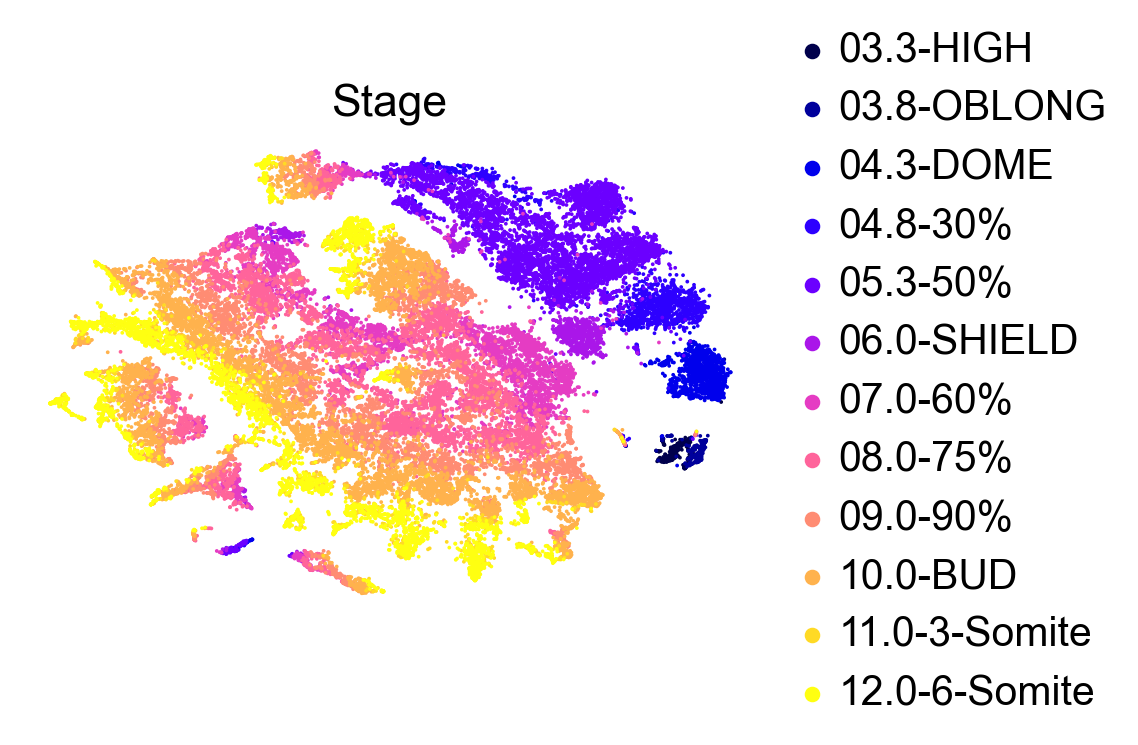

In [32]:
scv.pl.scatter(adata, basis='tsne', c=['Stage'], 
               legend_loc='right')

/Users/marius/Projects/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/marius/Projects/scvelo/scvelo/plotting/utils.py:967: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/marius/Projects/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


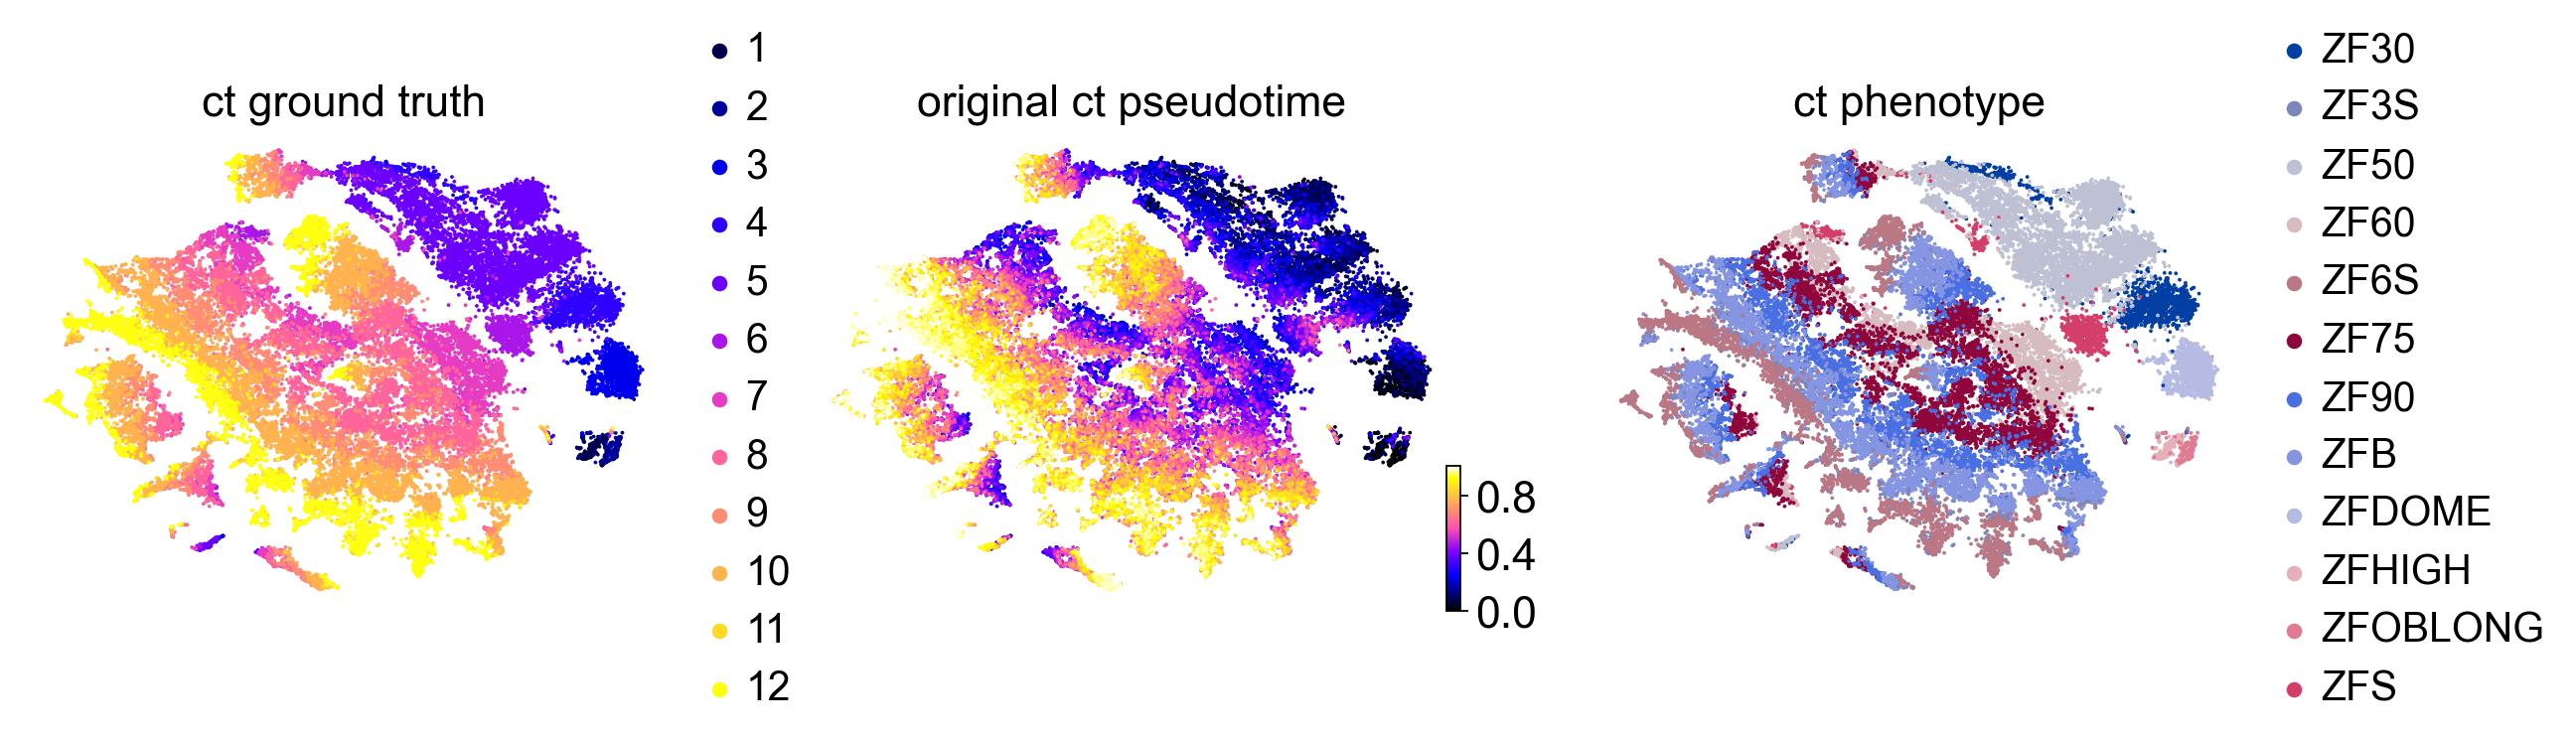

In [33]:
scv.pl.scatter(adata, basis='tsne', c=['ct_ground_truth', 'original_ct_pseudotime', 'ct_phenotype',], 
               legend_loc='right', color_map='gnuplot2')

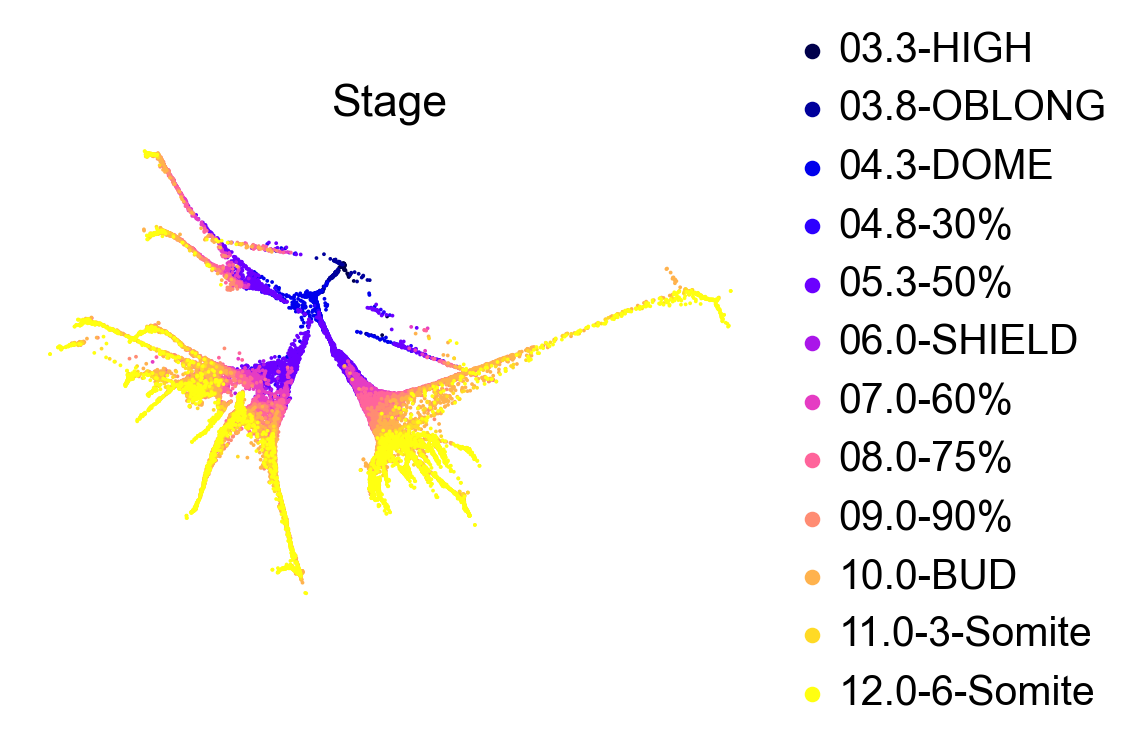

/Users/marius/Projects/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/marius/Projects/scvelo/scvelo/plotting/utils.py:967: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/marius/Projects/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


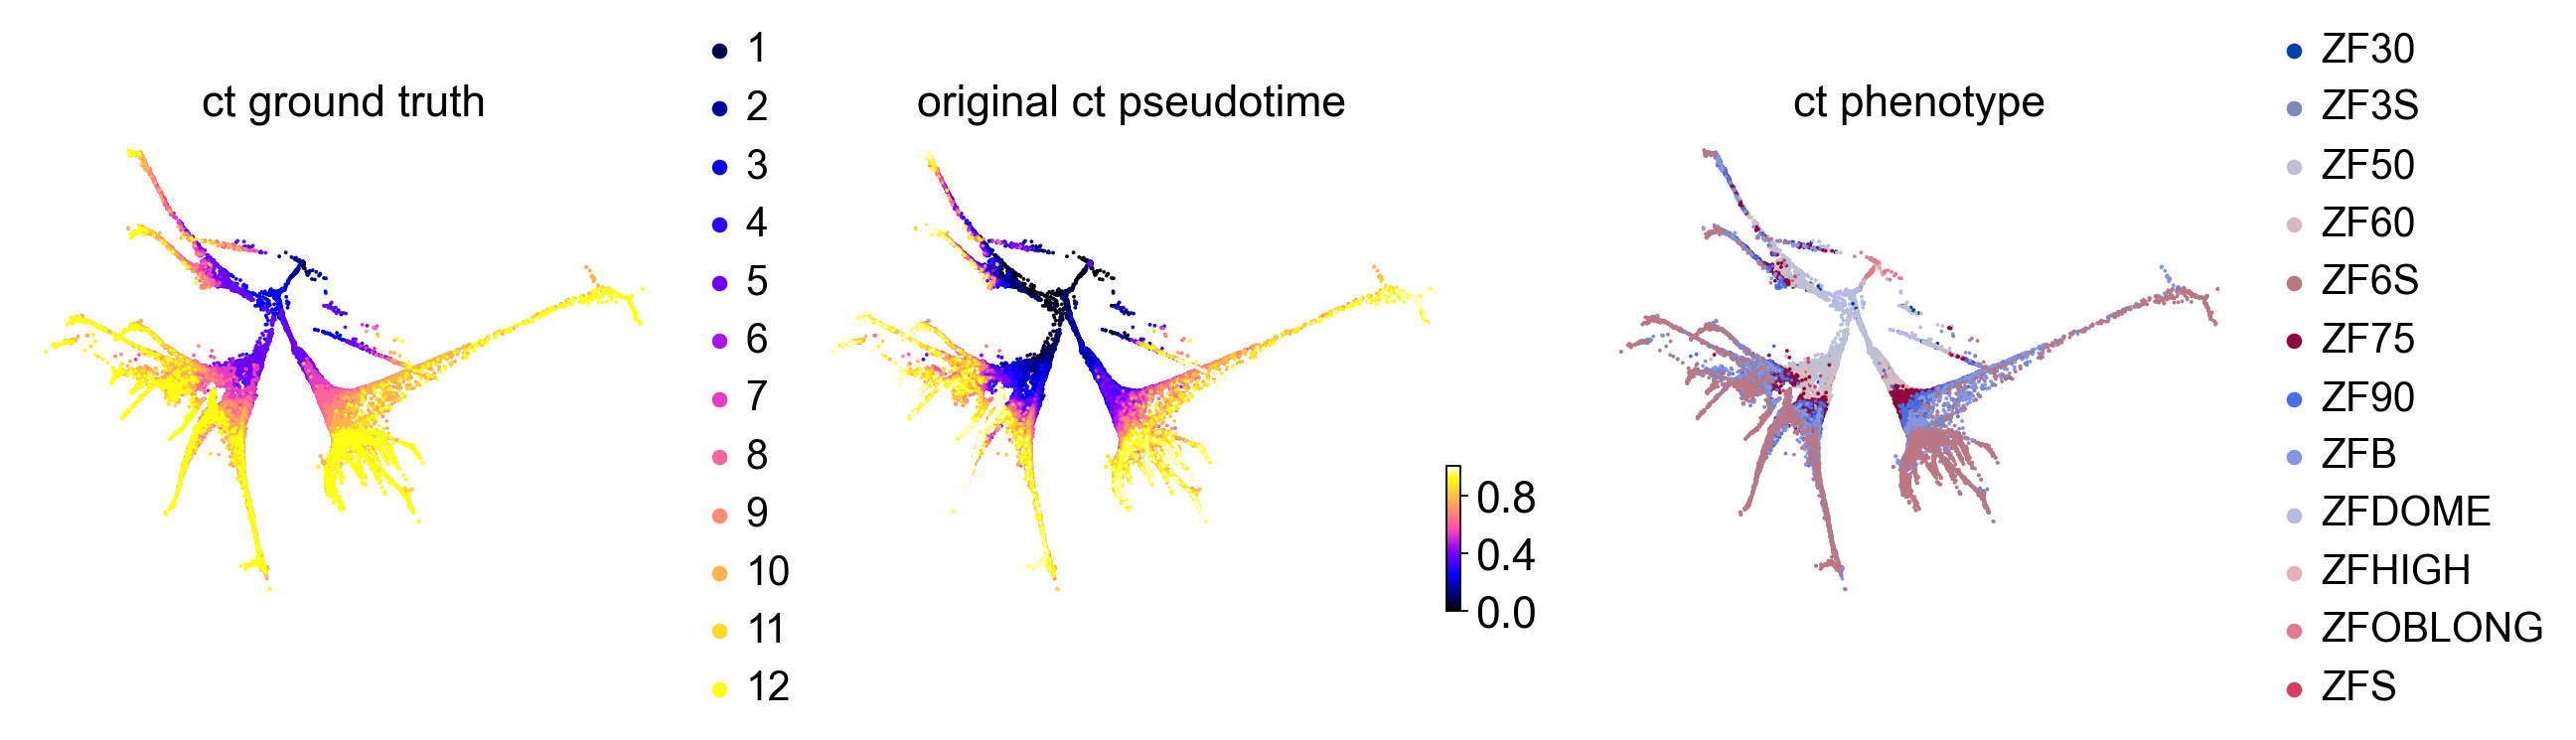

In [34]:
scv.pl.scatter(adata, basis='force_directed', c=['Stage'], 
               legend_loc='right')

scv.pl.scatter(adata, basis='force_directed', c=['ct_ground_truth', 'original_ct_pseudotime', 'ct_phenotype',], 
               legend_loc='right', color_map='gnuplot2')

Here's some ground truth on terminal states:

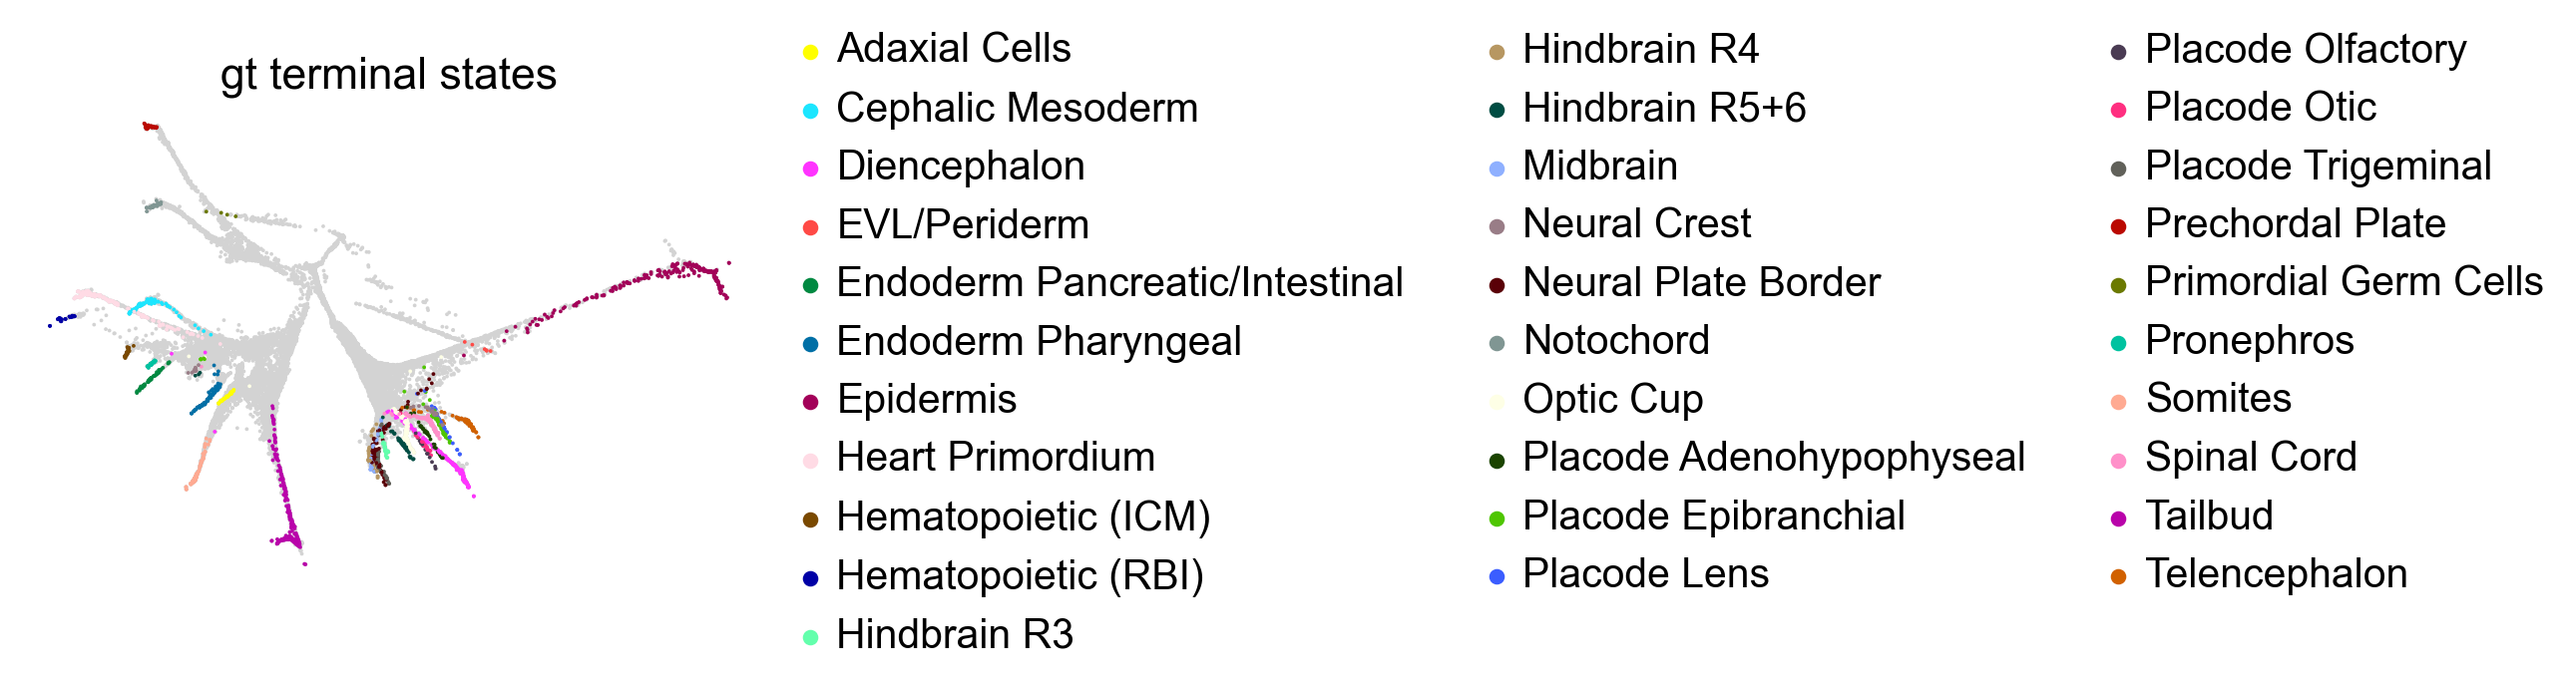

In [35]:
scv.pl.scatter(adata, basis='force_directed', c=['gt_terminal_states'], 
               legend_loc='right')

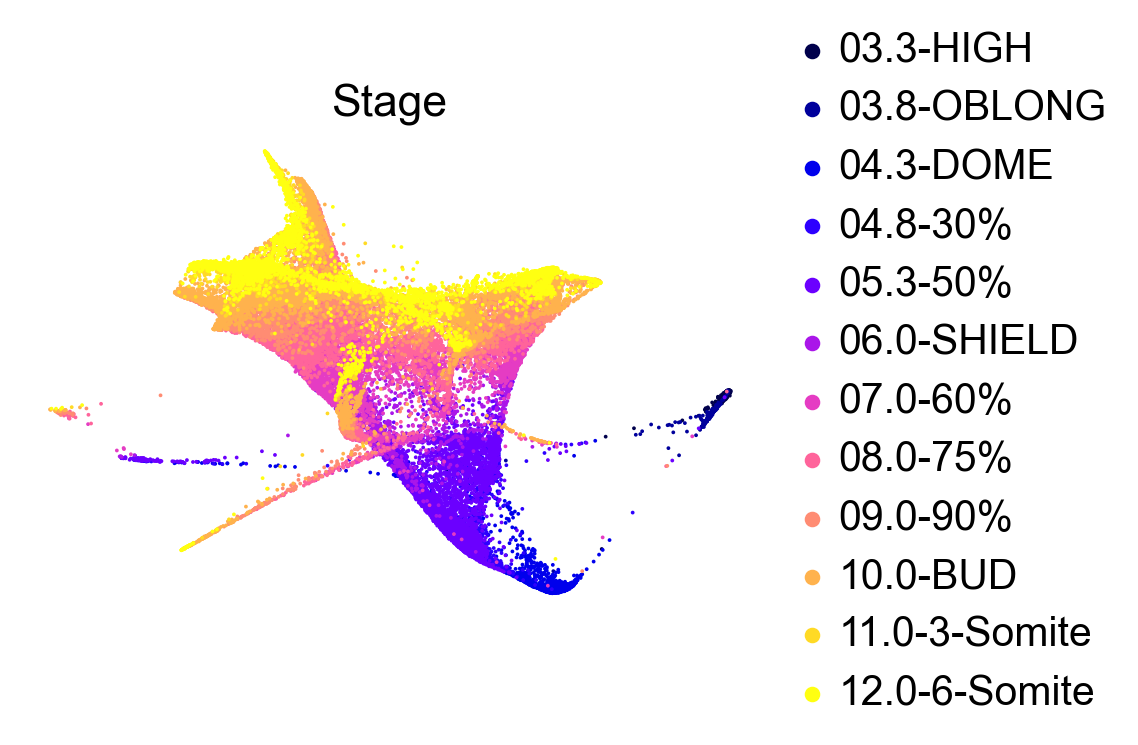

/Users/marius/Projects/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/marius/Projects/scvelo/scvelo/plotting/utils.py:967: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/marius/Projects/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


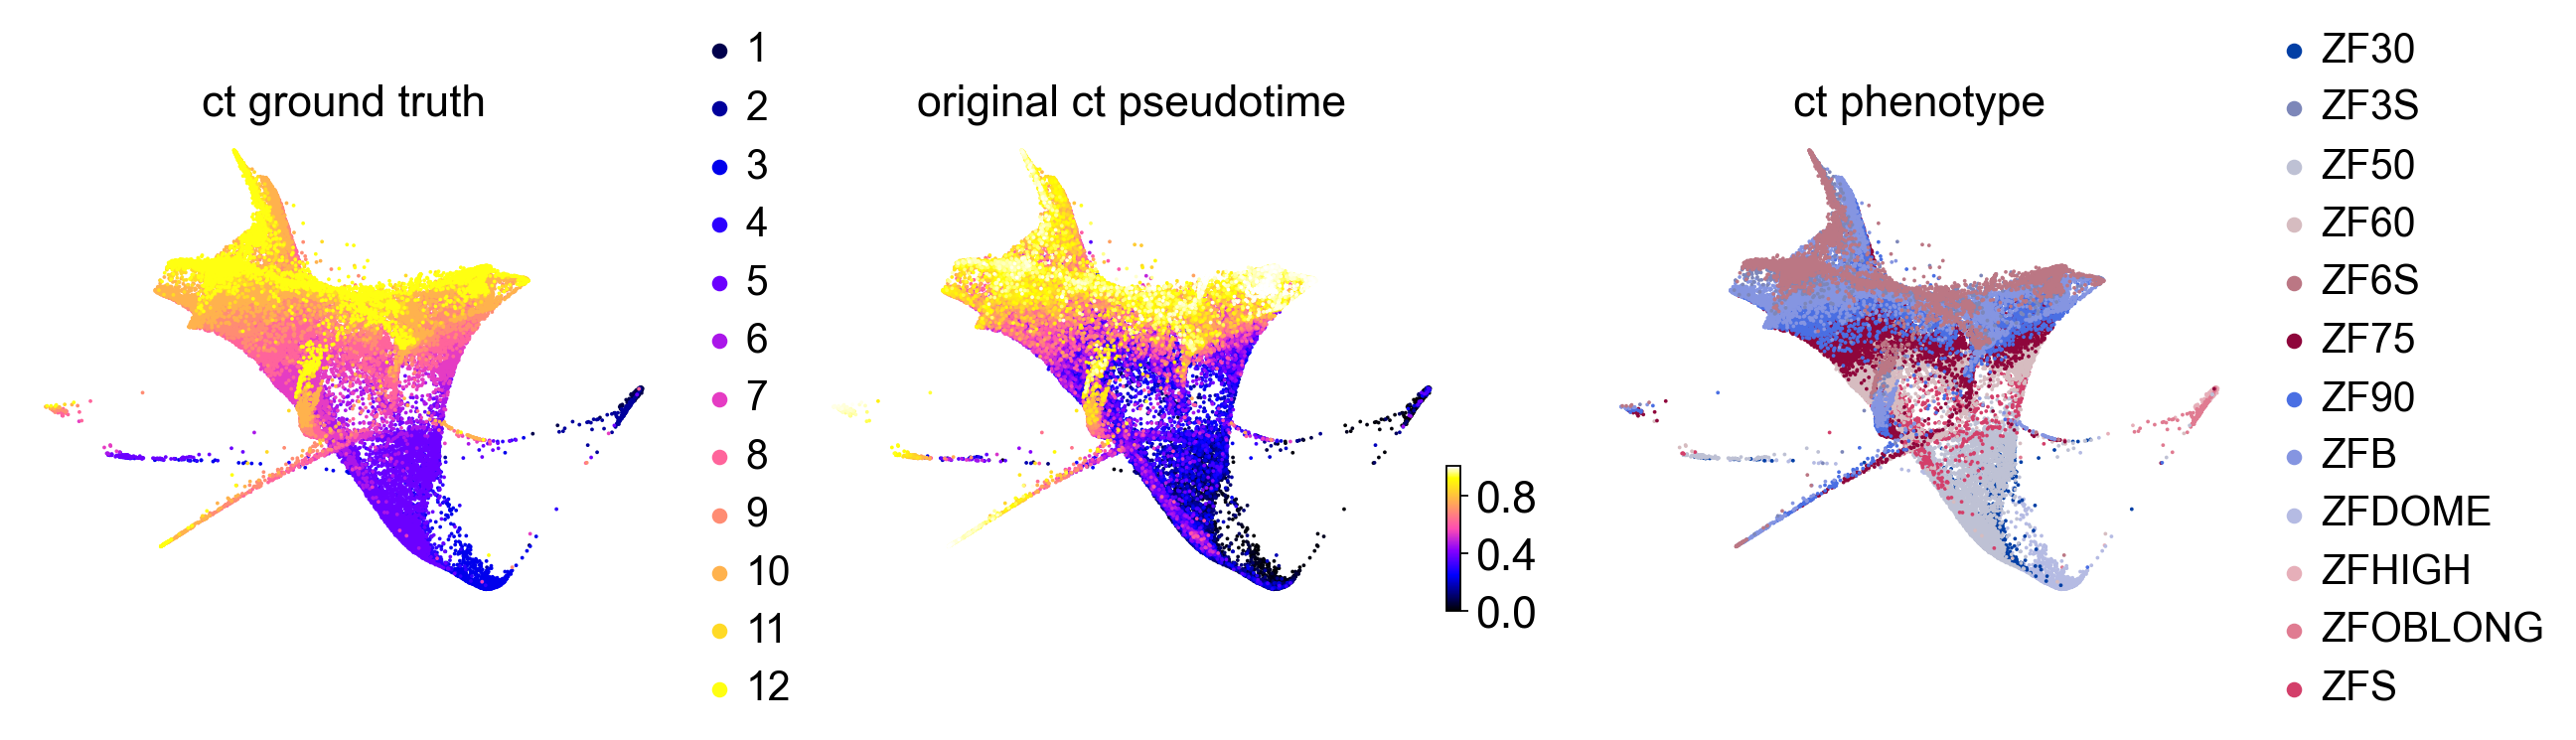

In [36]:
scv.pl.scatter(adata, basis='ct', c=['Stage'], 
               legend_loc='right')

scv.pl.scatter(adata, basis='ct', c=['ct_ground_truth', 'original_ct_pseudotime', 'ct_phenotype',], 
               legend_loc='right', color_map='gnuplot2')

Check all the many lineage annotations

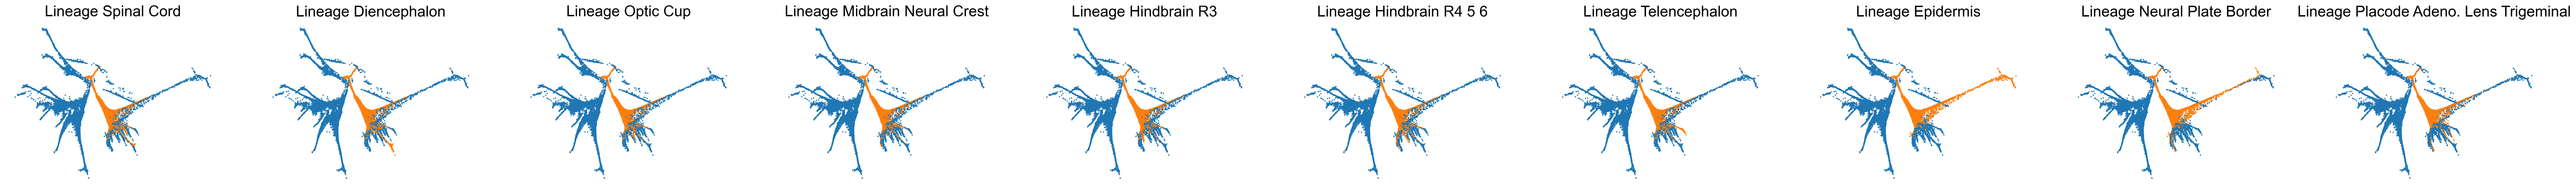

In [37]:
scv.pl.scatter(adata, c=[lin for lin in lineages_to_keep[:10]], basis='force_directed', dpi=100)

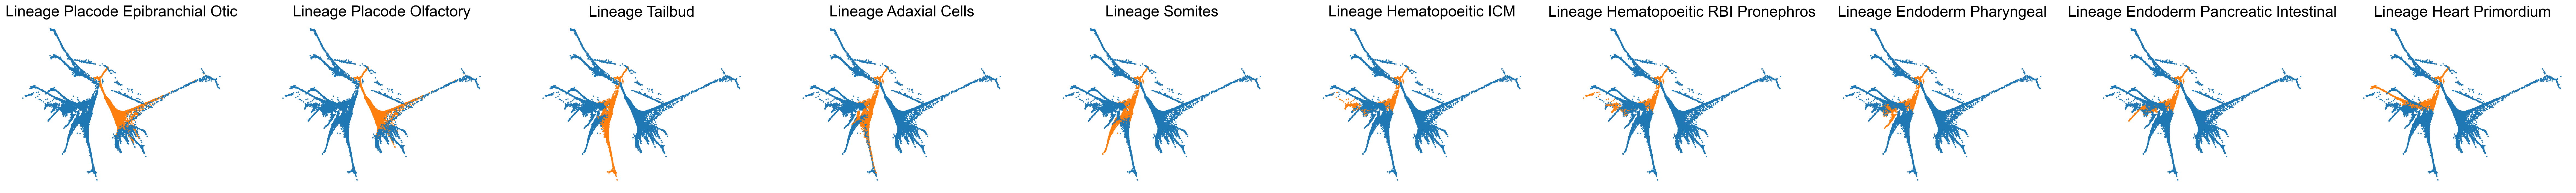

In [38]:
scv.pl.scatter(adata, c=[lin for lin in lineages_to_keep[10:20]], basis='force_directed', dpi=100)

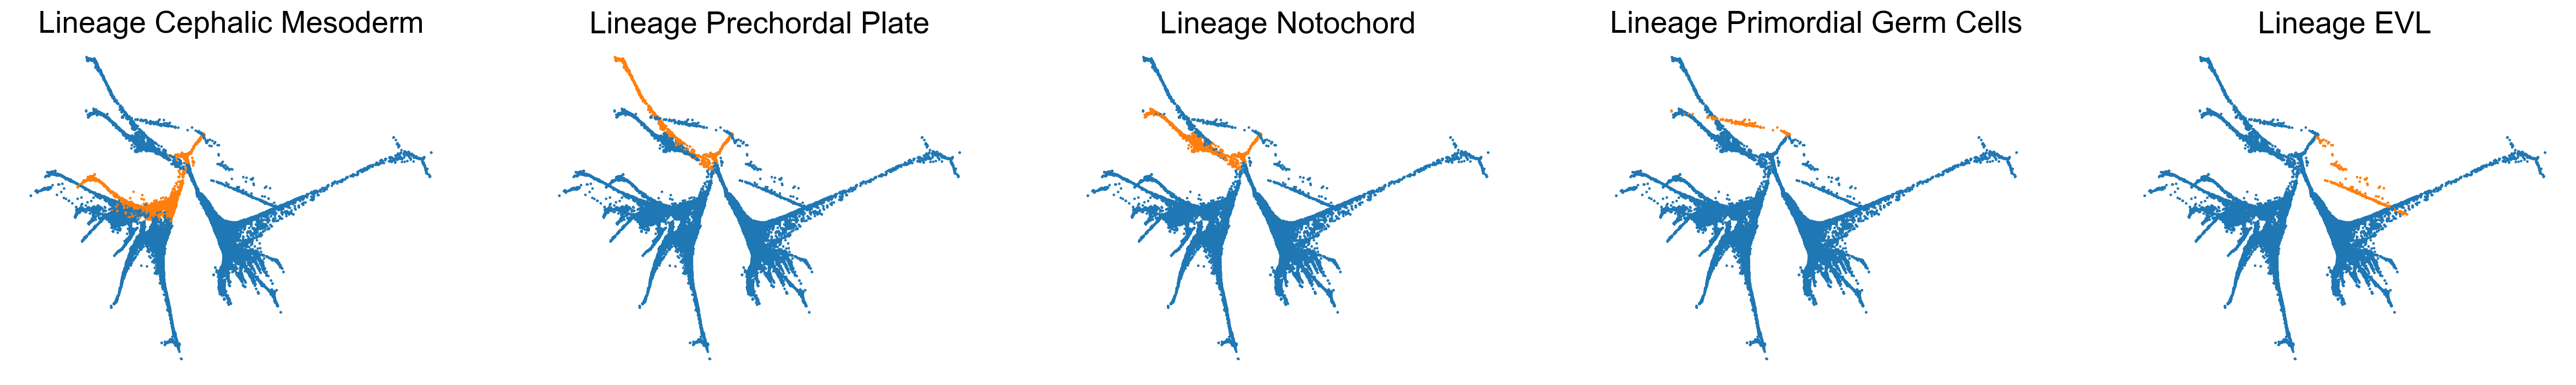

In [39]:
scv.pl.scatter(adata, c=[lin for lin in lineages_to_keep[20:]], basis='force_directed', dpi=100)

## Write data to file

Write the final AnnData object to file for faster loading in the future. 

In [40]:
adata.write(DATA_DIR / "zebrafish" / "ML-2023-07-17_zebrafish_merged.h5ad", compression="gzip")